- Installing Dependencies

In [14]:
pip install cmake dlib opencv-python numpy face-recognition matplotlib pillow

Note: you may need to restart the kernel to use updated packages.


- Installing training and testing dependencies

In [15]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import cv2  # For image processing
import os  # For handling file paths
import tensorflow as tf  # For model training

- Image Labelling 

In [16]:
# Path to the directory with images for encoding
path = 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset'
images = []
classNames = []
# List all items in the specified path and store images and class names
def makeClasses():
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            for img in os.listdir(cls_path):
                if not img.endswith('.DS_Store'):
                    images.append(os.path.join(cls_path, img))
                    classNames.append(cls)
    return classNames

classNames = makeClasses()

print("Image files:", images)
print("Class names:", classNames)

Image files: ['C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand1.jpeg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand1.jpg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand10.jpg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand11.jpg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand2.jpg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand3.jpg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand4.jpg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand4.png', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand5.jpg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand6.jpg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand7.jpg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand8.jpg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Anand\\Anand9.jpg', 'C:/Users/anand/Desktop/18Nov2024/Faces/dataset\\Bhavyasri\\1730133938782_yfp2ux_2_0.j

- Stratified k-fold Splitting code

In [17]:
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# Convert image paths and labels to numpy arrays for easier handling
image_paths = np.array(images)
labels = np.array(classNames)

folds = list(skf.split(images, classNames))

- Model Creation using keras

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model():
    model = Sequential([
        # Input layer
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),

        # Add more convolutional and pooling layers as needed
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Flatten the output
        Flatten(),

        # Dense layers
        Dense(128, activation='relu'),
        Dense(len(class_mapping), activation='softmax')  # Output layer
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

- Implementing face-crop and resizing functions

In [19]:
import cv2
import numpy as np
from PIL import Image

def detect_and_crop_faces(input_image):
    # Load OpenCV's Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    # If no faces detected, return the original image
    # if len(faces) == 0:
    #     print("No faces detected; returning original image.")
    #     return input_image

    # Crop the first detected face
    for (x, y, w, h) in faces:
        cropped_img = input_image[y:y+h, x:x+w]
        return cropped_img

    return input_image  # Fallback if faces detection fails

def resize_images(input_image):
    size = (224, 224)
    # Resize the image using OpenCV
    resized_img = cv2.resize(input_image, size)
    return resized_img

- Training and Evaluating the model

In [20]:
# Load images and preprocess them (resize and normalize)
def preprocess_images(paths):
    imageSet = []
    for path in paths:
        img = cv2.imread(path)  # Load the image

        if img is None:
            print(f"Error loading image: {path}")
            continue

        img_cropped = detect_and_crop_faces(img)  # Detect and crop faces
        img_resized = resize_images(img_cropped)  # Resize the image
        img_normalized = img_resized / 255.0  # Normalize pixel values to [0, 1]

        imageSet.append(img_normalized)
    return np.array(imageSet, dtype=np.float32)


for fold, (train_idx, val_idx) in enumerate(folds):
    print(f"Training Fold {fold + 1}/{len(folds)}")

    # Ensure these are numpy arrays
    images = np.array(images)
    classNames = np.array(classNames)
    
    # Split the data into training and validation sets
    train_images = images[train_idx]
    train_classNames = classNames[train_idx]
    val_images = images[val_idx]
    val_classNames = classNames[val_idx]

    # Preprocess the images
    X_train = preprocess_images(train_images)
    X_val = preprocess_images(val_images)
    
    # Convert class names to integers
    unique_classes = list(set(classNames))  # All unique class names
    class_mapping = {class_name: idx for idx, class_name in enumerate(unique_classes)}

    y_train = np.array([class_mapping[label] for label in train_classNames], dtype=np.int32)
    y_val = np.array([class_mapping[label] for label in val_classNames], dtype=np.int32)

    # Train the model
    model = create_model()
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Fold {fold + 1} - Loss: {val_loss}, Accuracy: {val_accuracy}")

Training Fold 1/7


C:\Users\anand\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.1084 - loss: 3.8680 - val_accuracy: 0.1818 - val_loss: 2.0161
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.2287 - loss: 1.9179 - val_accuracy: 0.0909 - val_loss: 1.9403
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1203 - loss: 1.9271 - val_accuracy: 0.3636 - val_loss: 1.9130
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.2946 - loss: 1.9027 - val_accuracy: 0.0909 - val_loss: 1.9611
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.1008 - loss: 1.9679 - val_accuracy: 0.1818 - val_loss: 1.8515
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3063 - loss: 1.7692 - val_accuracy: 0.0909 - val_loss: 1.9330
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.1319 - loss: 1.8418 - val_accuracy: 0.0909 - val_loss: 1.8707
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.2791 - loss: 1.6591 - val_accuracy: 0.1818 - val_loss: 1.7361
Epoch 9/1

- Calculating Precision, recall and F1 score

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

# After model evaluation
y_pred = model.predict(X_val).argmax(axis=1)  # Assuming one-hot encoded outputs
# zero_division=1 means that for labels with no predicted samples, the precision and recall are set to 1.0
precision = precision_score(y_val, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_val, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_val, y_pred, average='weighted', zero_division=1)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Precision: 0.63, Recall: 0.50, F1 Score: 0.45


- Plotting Loss and Accuracy Curves

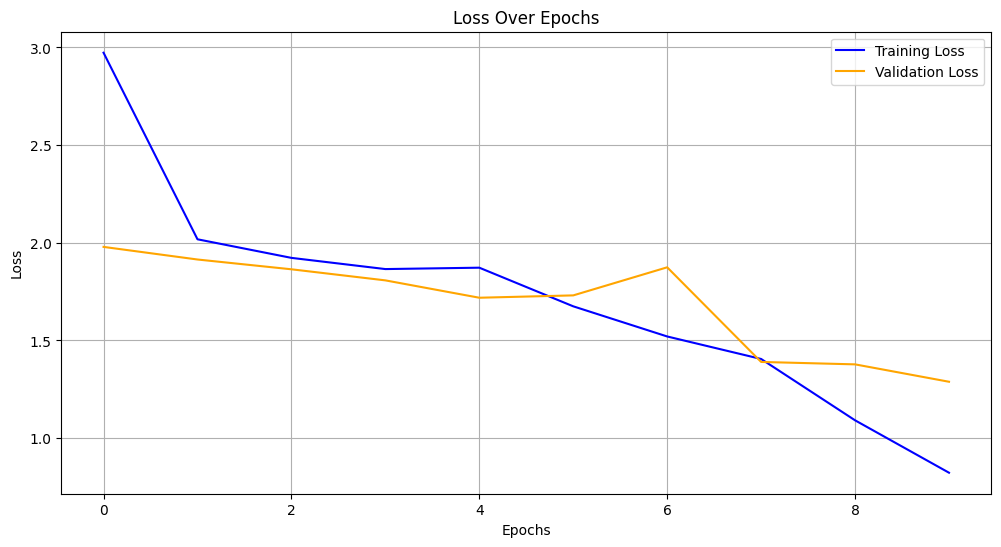

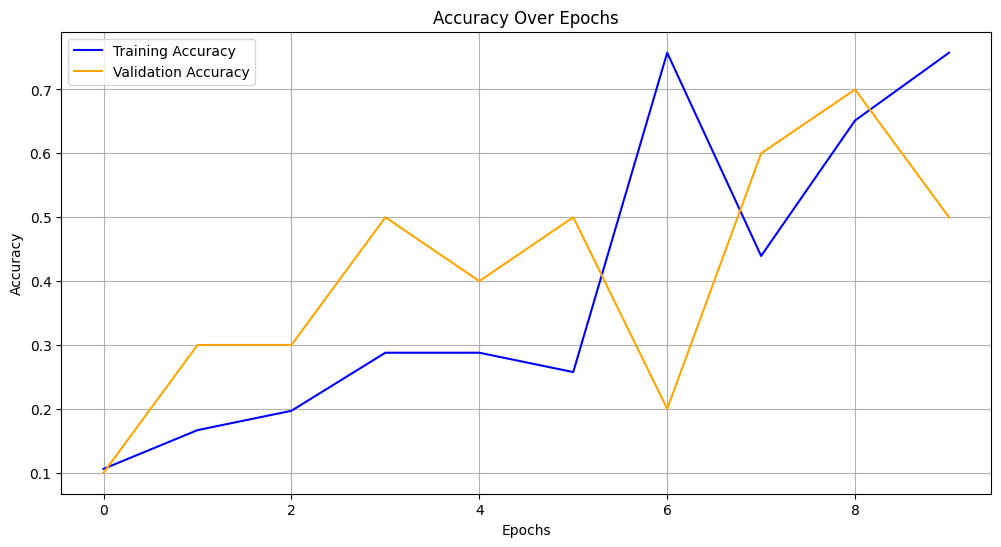

In [24]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
print("train_loss:", train_loss)
print("val_loss:", val_loss)
print("train_accuracy:", train_accuracy)
print("val_accuracy:", val_accuracy)

train_loss: [2.9731853008270264, 2.017909288406372, 1.9227211475372314, 1.8653703927993774, 1.8724653720855713, 1.674656629562378, 1.5202809572219849, 1.4050172567367554, 1.0909851789474487, 0.8226154446601868]
val_loss: [1.9789249897003174, 1.9143683910369873, 1.8642642498016357, 1.8075164556503296, 1.7186214923858643, 1.7306429147720337, 1.874402403831482, 1.3898605108261108, 1.3774433135986328, 1.2883917093276978]
train_accuracy: [0.10606060922145844, 0.1666666716337204, 0.19696970283985138, 0.28787878155708313, 0.28787878155708313, 0.25757575035095215, 0.7575757503509521, 0.43939393758773804, 0.6515151262283325, 0.7575757503509521]
val_accuracy: [0.10000000149011612, 0.30000001192092896, 0.30000001192092896, 0.5, 0.4000000059604645, 0.5, 0.20000000298023224, 0.6000000238418579, 0.699999988079071, 0.5]


In [31]:
import numpy as np

# Compute overall metrics
overall_accuracy = np.mean(val_accuracy)
overall_loss = np.mean(val_loss)
print("---------------------------")
print("Estimated Overall Performance:\n")
print(f"Overall Accuracy: {overall_accuracy:.2f}")
print(f"Overall Loss: {overall_loss:.2f}\n")

print("---------------------------")

---------------------------
Estimated Overall Performance:

Overall Accuracy: 0.41
Overall Loss: 1.69

---------------------------


- Image Encoding into 128 dimensional vector

In [9]:
import face_recognition

# Function for encoding faces
print("encoding start")
counter = 0
def findEncodings(images):
    global counter
    encodeList = []
    for img_path in images:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error loading image: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        encodes = face_recognition.face_encodings(img)
        if encodes:
            encodeList.append(encodes[0]) # Use the first encoding if present
            counter+=1      
            print(f'encoded image: {counter}')
        else:
            print(f"No face found in image: {img_path}")
    
    # Validation message after processing all images
    if encodeList:
        print(f"Encoding complete. {len(encodeList)} face(s) encoded successfully.")
    else:
        print("Encoding complete. No faces were found in the provided images.")
    
    return encodeList

encodeListKnown = findEncodings(images)

encoding start
encoded image: 1
encoded image: 2
encoded image: 3
encoded image: 4
encoded image: 5
encoded image: 6
encoded image: 7
encoded image: 8
encoded image: 9
encoded image: 10
encoded image: 11
encoded image: 12
encoded image: 13
encoded image: 14
encoded image: 15
encoded image: 16
encoded image: 17
encoded image: 18
encoded image: 19
encoded image: 20
encoded image: 21
encoded image: 22
encoded image: 23
encoded image: 24
encoded image: 25
encoded image: 26
encoded image: 27
encoded image: 28
encoded image: 29
encoded image: 30
encoded image: 31
encoded image: 32
encoded image: 33
encoded image: 34
encoded image: 35
encoded image: 36
encoded image: 37
encoded image: 38
encoded image: 39
encoded image: 40
encoded image: 41
encoded image: 42
encoded image: 43
encoded image: 44
encoded image: 45
encoded image: 46
encoded image: 47
encoded image: 48
encoded image: 49
encoded image: 50
encoded image: 51
encoded image: 52
encoded image: 53
encoded image: 54
encoded image: 55
enco

- Forming the pickle file

In [2]:
import os
import pickle

# Save or load encodings
if not os.path.exists("encodings.pkl"):
    with open("encodings.pkl", "wb") as f:
        pickle.dump((encodeListKnown, classNames), f)
    print("Encodings computed and saved to file.")
else:
    with open("encodings.pkl", "rb") as f:
        encodeListKnown, classNames = pickle.load(f)
    print("Encodings loaded from file.")

Encodings loaded from file.


- Model Summary

In [32]:
import numpy as np

# className = makeClasses()
unique_ClassNames = set(classNames)  # Set of unique class names

def model_summary(encodeListKnown, unique_ClassNames):
    print("Model Summary:")
    print("--------------------")
    
    # Basic Details
    num_faces_encoded = len(encodeListKnown)
    encoding_dim = len(encodeListKnown[0]) if encodeListKnown else 'N/A'
    
    # Display Basic Information
    print(f"Number of faces encoded: {num_faces_encoded}")
    print(f"Encoding vector dimension: {encoding_dim}")
    print(f"Number of unique classes: {len(unique_ClassNames)}")
    
    # Class Information
    print("All class names:", list(unique_ClassNames))  # Print all unique class names
    
    # Distribution of Classes
    # class_counts = {class_name: classNames.count(class_name) for class_name in unique_ClassNames}
    class_counts = {class_name: np.count_nonzero(classNames == class_name) for class_name in unique_ClassNames}
    print("\nClass Distribution:")
    for class_name, count in class_counts.items():
        print(f" - {class_name}: {count} instances")
    
    print("--------------------")

# Call the function with your data
model_summary(encodeListKnown, unique_ClassNames)

Model Summary:
--------------------
Number of faces encoded: 76
Encoding vector dimension: 128
Number of unique classes: 7
All class names: ['Bhavyasri', 'Anand', 'Gaurav', 'Heriv', 'Karan', 'Mythili', 'Harsh']

Class Distribution:
 - Bhavyasri: 15 instances
 - Anand: 13 instances
 - Gaurav: 16 instances
 - Heriv: 10 instances
 - Karan: 7 instances
 - Mythili: 7 instances
 - Harsh: 8 instances
--------------------


- Attendance function 

In [33]:
from datetime import datetime
import os

print("Attendance marking function start")

# Generate a unique filename using the current date and time
now = datetime.now()
date_str = now.strftime('%Y-%m-%d_%H-%M-%S')
attendance_file = f'Attendance_{date_str}.csv'

def markAttendance(name):
    # Check if the attendance file exists, create it with a header if not
    if not os.path.isfile(attendance_file):
        with open(attendance_file, 'w') as f:
            f.write('Name,Time\n')  # Create the header

    with open(attendance_file, 'a+') as f:
        f.seek(0)  # Move to the beginning of the file to read
        myDateList = f.readlines()
        nameList = [line.split(',')[0] for line in myDateList[1:]]  # Skip header to get names only
        if name not in nameList:
            now = datetime.now()
            dtString = now.strftime('%H:%M:%S')
            f.write(f'{name},{dtString}\n')  # Append attendance

print("Function end")

Attendance marking function start
Function end


- Face capturing function

In [ ]:
import cv2
import numpy as np
import face_recognition
import pandas as pd
import time

print("Starting capture...")
cap = cv2.VideoCapture(0)
Student_Set = set()

# Number of iterations for averaging
num_iterations = 20
distance_records = []
name_distance_list = []  # To store names and corresponding average distances

unrecognized_timer = {}  # To track time for unrecognized faces
unknown_faces = []  # To store unrecognized face entries

counter = 0

while True:
    counter += 1
    success, img = cap.read()
    if not success:
        print("Failed to capture image.")
        break
    
    imgSmall = cv2.resize(img, (0, 0), fx=0.25, fy=0.25)
    imgSmall = cv2.cvtColor(imgSmall, cv2.COLOR_BGR2RGB)

    # Detect faces and encode them
    facesCurrFrame = face_recognition.face_locations(imgSmall)
    encodesCurrFrame = face_recognition.face_encodings(imgSmall, facesCurrFrame)

    # Process each face detected in the current frame
    for encodeFace, faceLoc in zip(encodesCurrFrame, facesCurrFrame):
        matches = face_recognition.compare_faces(encodeListKnown, encodeFace)
        faceDis = face_recognition.face_distance(encodeListKnown, encodeFace)

        # Count the matches for the closest known face
        matchCount = np.sum(np.array(matches) & (faceDis < 0.45))  # Adjust threshold as needed

        if matchCount >= 5:  # Require at least 5 matches for identification
            matchIndex = np.argmin(faceDis)
            name = classNames[matchIndex].upper()
            Student_Set.add(name)
            name_distance_list.append({'Name': name, 'Distance': np.mean(faceDis[matches])})

            # Reset unrecognized timer for this face
            unrecognized_timer.pop(faceLoc, None)

            # Draw rectangle and name
            y1, x2, y2, x1 = faceLoc
            cv2.rectangle(img, (x1*4, y1*4), (x2*4, y2*4), (0, 255, 0), 2)
            cv2.rectangle(img, (x1*4, y2*4 - 35), (x2*4, y2*4), (0, 255, 0), cv2.FILLED)
            cv2.putText(img, name, (x1*4 + 6, y2*4 - 6), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
            markAttendance(name)
        else:
            # Handle unrecognized faces
            if faceLoc not in unrecognized_timer:
                unrecognized_timer[faceLoc] = time.time()  # Start timer for this face
            else:
                elapsed_time = time.time() - unrecognized_timer[faceLoc]
                if elapsed_time > 5:  # If the face remains unrecognized for 10 seconds
                    name = "Unknown Face"
                    unknown_faces.append({'Time': time.strftime('%Y-%m-%d %H:%M:%S'), 'Status': name})

                    # Draw rectangle and label "Unknown Face"
                    y1, x2, y2, x1 = faceLoc
                    cv2.rectangle(img, (x1*4, y1*4), (x2*4, y2*4), (0, 0, 255), 2)
                    cv2.rectangle(img, (x1*4, y2*4 - 35), (x2*4, y2*4), (0, 0, 255), cv2.FILLED)
                    cv2.putText(img, name, (x1*4 + 6, y2*4 - 6), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
                    # Remove the timer entry for this face
                    unrecognized_timer.pop(faceLoc, None)

    # Show the captured image with any recognized or unrecognized face
    cv2.imshow('Webcam', img)
    
    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Display final set of recognized names
print("\nFinal Recognized Set:")
print(Student_Set)

# Display the tabulated output of names and distances
if name_distance_list:
    df = pd.DataFrame(name_distance_list)
    print("\nRecognition Details (Name and Average Distance):")
    print(df.groupby('Name').min().reset_index())  # Show unique names with minimum distance recorded

# Log unknown faces to an Excel sheet
# if unknown_faces:
#     df_unknown = pd.DataFrame(unknown_faces)
#     df_unknown.to_excel('Unknown_Faces.xlsx', index=False)
#     print("\nUnknown faces logged to 'Unknown_Faces.xlsx'.")

# Release the capture and destroy all OpenCV windows
cap.release()
cv2.destroyAllWindows()

Starting capture...
